In [287]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import sklearn

In [288]:
# DATA
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

Tz  = np.array(df['room_temp']).reshape(-1,1)
Tsa = np.array(df['supply_discharge_temp']).reshape(-1,1)
msa = np.array(df['airflow_current']).reshape(-1,1)
z   = ((msa-400)/600)*(Tsa-Tz)

n_train = 64

Tz_k   = Tz[0:n_train]
y      = Tz[1:n_train+1]
Tsa_k1 = Tsa[1:n_train+1]
msa_k1 = msa[1:n_train+1]
z      = ((msa_k1-400)/600)*(Tsa_k1-Tz_k)
ones   = np.ones((n_train,1))

x0     = np.copy(Tz_k)
x1     = np.copy(z)
x02    = x0**2
x12    = x1**2
x0x1   = x0*x1
x03    = x0**3
x13    = x1**3
x02x1  = x0*x0*x1
x0x12  = x0*x1*x1

x0_t = Tz[n_train:-1]
y_t  = Tz[n_train+1:]
x1_t = ((msa[n_train+1:]-400)/600)*(Tsa[n_train+1:]-x0_t)
ones_t = np.ones((Tz.shape[0]-n_train-1, 1))

A = np.concatenate((ones, x0, x1, x02, x12, x0x1, x03, x13, x02x1, x0x12), axis=1)
b = np.copy(y)

In [289]:
# SINDy with STLS
alpha = 0.001
para = ()
A1 = np.copy(A)
while(1):
    c = np.linalg.lstsq(A1, b, rcond=-1)[0]
    c = c*(np.abs(c)>alpha)
    para = para + (c,)

    cols = np.array([], dtype=np.int32)
    for i in range(c.shape[0]):
        if c[i] == 0:
            cols = np.append(cols, i)
    if(cols.shape[0] == 0): break
    A1 = np.delete(A1, cols, axis=1)

In [290]:
# STLS
def transfer(long, short):
    cols = np.where(long != 0)[0]
    out = np.copy(long)
    for i, c in enumerate(cols):
        out[c] = short[i]
    return out

def convert(para):
    c = para[len(para)-1]
    for i in range(len(para)-1):
        c = transfer(para[len(para) - 2 - i], c)
    return c

c = convert(para)
print("Number of terms:", np.sum((c!=0)))

Number of terms: 5


In [291]:
# System
def system(one, x0, x1):
    return c[0]*one + c[1]*x0 + c[2]*x1 + \
           c[3]*x0**2 + c[4]*x1**2 + c[5]*x0*x1 + \
           c[6]*x0**3 + c[7]*x1**3 + c[8]*x0*x0*x1 + c[9]*x0*x1*x1

RMSE: 0.07651486184283099
R2:   0.9955314223074988


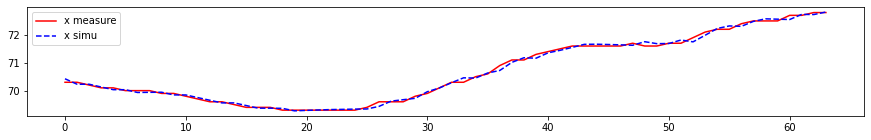

In [292]:
x_simu = system(ones, x0, x1)
print("RMSE:", np.sqrt(np.mean(np.square(x_simu - y))))
print("R2:  ", sklearn.metrics.r2_score(y, x_simu))

# plot
plt.figure(figsize=(15,2))
plt.plot(y,      'r-',  label='x measure')
plt.plot(x_simu, 'b--', label='x simu')
plt.legend()
plt.show()

RMSE: 0.08396241736754881
R2:   0.9979413081499043


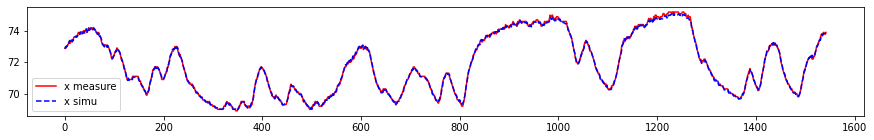

In [293]:
x_simu = system(ones_t, x0_t, x1_t)
print("RMSE:", np.sqrt(np.mean(np.square(x_simu - y_t))))
print("R2:  ", sklearn.metrics.r2_score(y_t, x_simu))

# plot
plt.figure(figsize=(15,2))
plt.plot(y_t,    'r-',  label='x measure')
plt.plot(x_simu, 'b--', label='x simu')
plt.legend()
plt.show()